### Imports

In [1]:
import arcgis
from arcgis.gis import GIS
from ipywidgets import Layout
from PIL import Image
from keras.preprocessing import image
from keras.models import load_model, model_from_json
from keras import optimizers, regularizers, models, layers
import requests
from io import BytesIO
from urllib.parse import urlencode
from os import listdir, remove, mkdir
from os.path import join, exists, expanduser, isdir
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
from file_utils import make_dir_helper, is_jpeg, delete_dir_helper, delete_dir_files_helper
import numpy as np

Using TensorFlow backend.


In [34]:
arcgis.__version__

'1.2.0'

### Path Constants

In [2]:
PROJECT_DIR = join(expanduser('~'),'desktop','Esri Project');
MAP_NAME = 'map.jpg'
MAP_DIR = join(PROJECT_DIR, 'maps')
SLICED_DIR = join(MAP_DIR, 'sliced')
TEMP_SLICED_DIR = join(MAP_DIR, 'temp sliced')
DATA_DIR = join(PROJECT_DIR, 'original data 3')
MODEL_PATH =  join(expanduser('~'),  PROJECT_DIR, 'models', 'map_multi_model_redlands_1.h5');

In [3]:
classes = [dname for dname in listdir(DATA_DIR) if isdir(join(DATA_DIR, dname))]
overlay_color_options = {
           0 : (0, 255, 0, 100),
           1 : (0, 255, 0, 100),
           2 : (0, 255, 255, 100),
           3 : (255, 255, 0, 100),
           4 : (0, 255, 0, 0),
           5 : (0, 0, 255, 100),
}

### Slice Constants

In [4]:
SLICE_WIDTH, SLICE_HEIGHT = 256, 256
MAP_WIDTH, MAP_HEIGHT = 4096, 4096

In [5]:
gis = GIS()
arc_map = gis.map('redlands')

arc_map.basemap = 'satellite'
arc_map

### Download map using the current extent

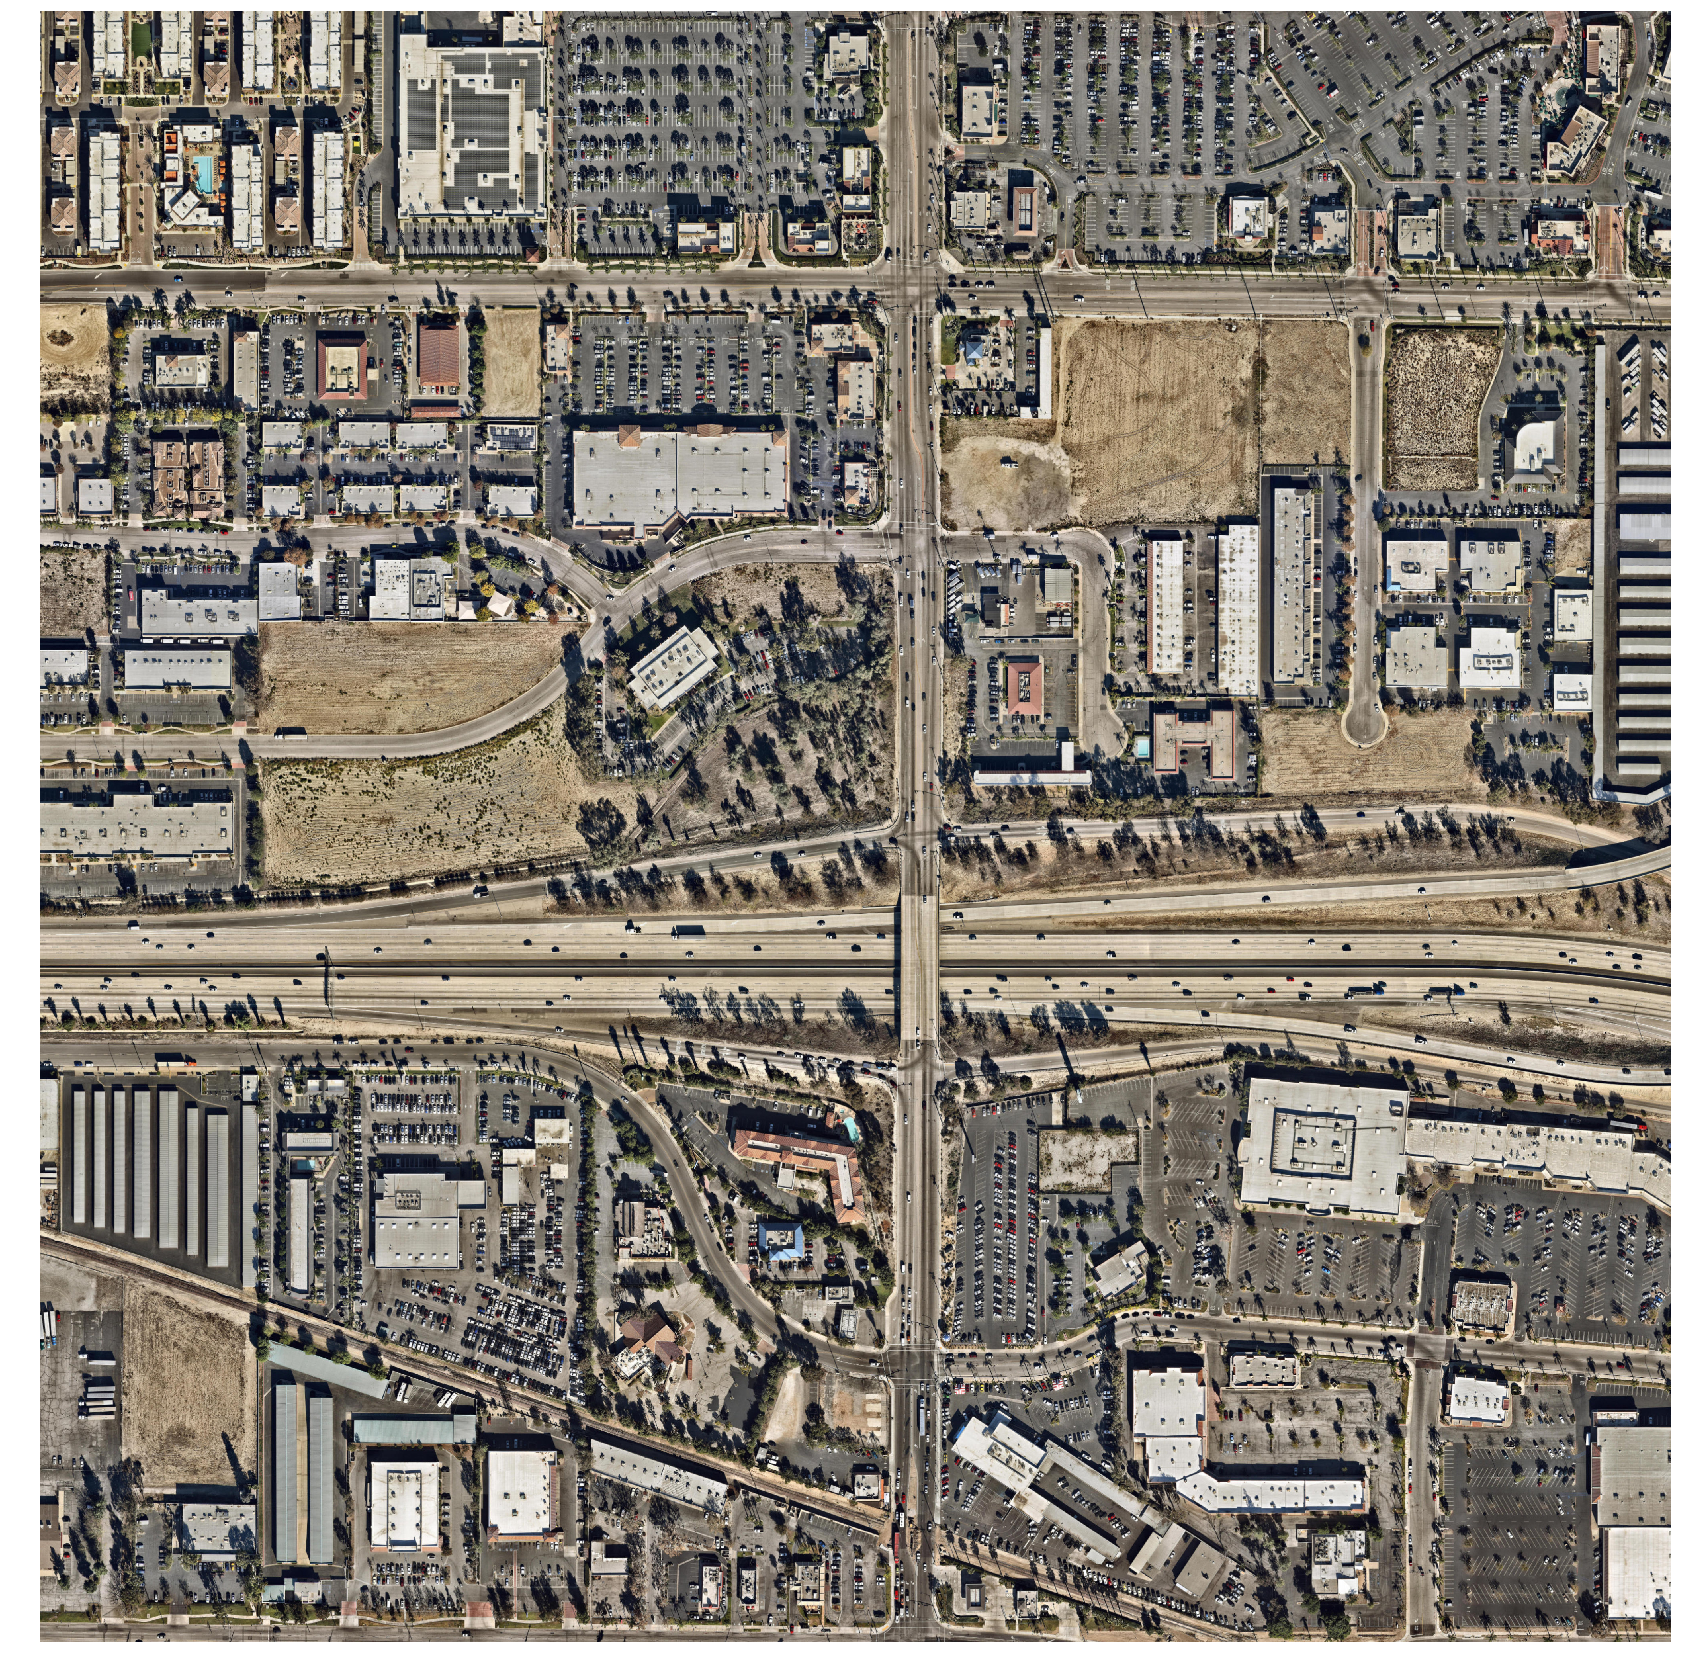

In [7]:
URL = 'https://services.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/export?'
extent = arc_map.extent

y_delta = 0

parameters = {
    'bbox':'{},{},{},{}'.format(extent['xmin'], extent['ymin'], extent['xmax'], extent['ymax'] + y_delta),
    'bboxSR':extent['spatialReference']['latestWkid'],
    'size':'{},{}'.format(MAP_WIDTH, MAP_HEIGHT),
    'format':'jpg',
    'f':'image'
}

URL += urlencode(parameters)

MAP_FILE_PATH = join(MAP_DIR, MAP_NAME)

if urlretrieve(URL, MAP_FILE_PATH):
    
    img = image.load_img(MAP_FILE_PATH, target_size=(MAP_HEIGHT, MAP_WIDTH)) 
    plt.figure(figsize=(30, 30)) 
    plt.imshow(img)
    plt.axis('off')
    plt.show()

### Slice map into tiles

In [ ]:
with Image.open(MAP_FILE_PATH) as im:
    imgwidth, imgheight = im.size
    SLICE_WIDTH, SLICE_HEIGHT = 128, 128
    idx = 0
    start_idx = 320 * 20
    for i in range(0, imgheight - SLICE_HEIGHT , SLICE_HEIGHT):
        for j in range(0, imgwidth - SLICE_WIDTH , SLICE_WIDTH):
            box = (j, i, j + SLICE_WIDTH, i + SLICE_HEIGHT)
            try:
                cropped_image = im.crop(box)
                cropped_image.save(join(SLICED_DIR, 'image_{}.jpg'.format(start_idx + idx)), "JPEG", quality=100, optimize=True)
            except:
                traceback.print_exc()
                pass
            idx +=1

### Slice and predict the map

In [46]:
def predict_class_overlay(img, model):
    
    img_resized = img.resize((128,128), Image.ANTIALIAS)
    img_tensor = image.img_to_array(img_resized)
    img_tensor = img_tensor.reshape((1,) + img_tensor.shape)
    img_tensor /= 255.
    predictions = model.predict(img_tensor)[0]
    max_val = np.amax(predictions)
    max_index = np.argmax(predictions)
    
    return overlay_color_options[max_index]


with Image.open(MAP_FILE_PATH) as im:
    
    imgwidth, imgheight = im.size
    imgwidth, imgheight = imgwidth //2, imgheight // 2
    SLICE_WIDTH, SLICE_HEIGHT = 256, 256
    modified_image = Image.new('RGB', (imgwidth, imgheight))
    idx = 0
    y_offset = 0
    model = load_model(MODEL_PATH)
    model.compile(loss='categorical_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4),metrics=['acc'])
    
    for i in range(0, imgheight , SLICE_HEIGHT):
        x_offset = 0
        for j in range(0, imgwidth , SLICE_WIDTH):
            box = (j, i, j + SLICE_WIDTH, i + SLICE_HEIGHT)
            try:
                 
                cropped_image = im.crop(box)
                overlay_color = predict_class_overlay(cropped_image, model)
              
                overlay = Image.new('RGBA', ( SLICE_WIDTH, SLICE_HEIGHT), overlay_color)
                cropped_image.paste(overlay, (0, 0), overlay)
                # cropped_image.save(join(TEMP_SLICED_DIR, 'image_{}.jpg'.format(idx)), "JPEG", quality=100, optimize=True)
                
                modified_image.paste(cropped_image, (x_offset, y_offset))
                x_offset = x_offset + SLICE_WIDTH
                
            except:
                traceback.print_exc()
                pass
            idx +=1
        y_offset = y_offset + SLICE_HEIGHT
    modified_image.save(join(MAP_DIR, 'modified_map_2.jpg'), "JPEG", quality=100, optimize=True)
    plt.figure(figsize=(30, 30)) 
    plt.imshow(modified_image)
    plt.axis('off')
    plt.show()

ResourceExhaustedError: OOM when allocating tensor with shape[3,3,64,64]
	 [[Node: block1_conv2_20/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=6654837, _device="/job:localhost/replica:0/task:0/gpu:0"](block1_conv2_20/random_uniform/shape)]]

Caused by op 'block1_conv2_20/random_uniform/RandomUniform', defined at:
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-46-a6ad4503891d>", line 22, in <module>
    model = load_model(MODEL_PATH)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\models.py", line 233, in load_model
    model = model_from_config(model_config, custom_objects=custom_objects)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\models.py", line 307, in model_from_config
    return layer_module.deserialize(config, custom_objects=custom_objects)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\layers\__init__.py", line 54, in deserialize
    printable_module_name='layer')
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\utils\generic_utils.py", line 139, in deserialize_keras_object
    list(custom_objects.items())))
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\models.py", line 1209, in from_config
    layer = layer_module.deserialize(conf, custom_objects=custom_objects)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\layers\__init__.py", line 54, in deserialize
    printable_module_name='layer')
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\utils\generic_utils.py", line 139, in deserialize_keras_object
    list(custom_objects.items())))
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\engine\topology.py", line 2450, in from_config
    process_layer(layer_data)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\engine\topology.py", line 2445, in process_layer
    layer(input_tensors[0], **kwargs)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\engine\topology.py", line 569, in __call__
    self.build(input_shapes[0])
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\layers\convolutional.py", line 134, in build
    constraint=self.kernel_constraint)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\legacy\interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\engine\topology.py", line 391, in add_weight
    weight = K.variable(initializer(shape), dtype=dtype, name=name)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\initializers.py", line 208, in __call__
    dtype=dtype, seed=self.seed)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py", line 3536, in random_uniform
    dtype=dtype, seed=seed)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\tensorflow\python\ops\random_ops.py", line 236, in random_uniform
    shape, dtype, seed=seed1, seed2=seed2)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_random_ops.py", line 263, in _random_uniform
    seed=seed, seed2=seed2, name=name)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[3,3,64,64]
	 [[Node: block1_conv2_20/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=6654837, _device="/job:localhost/replica:0/task:0/gpu:0"](block1_conv2_20/random_uniform/shape)]]


In [38]:
with Image.open(MAP_FILE_PATH) as im:
    
    imgwidth, imgheight = im.size
    SLICE_WIDTH, SLICE_HEIGHT = 128, 128
    idx = 0       
    for i in range(0, imgheight , SLICE_HEIGHT):
        x_offset = 0
        for j in range(0, imgwidth , SLICE_WIDTH):
            box = (j, i, j + SLICE_WIDTH, i + SLICE_HEIGHT)
            try:
                 
                cropped_image = im.crop(box)
                cropped_image.save(join(TEMP_SLICED_DIR, 'image_{}.jpg'.format(idx)), "JPEG", quality=100, optimize=True)    
                
            except:
                traceback.print_exc()
                pass
            idx +=1
cropped_images = np.array([np.array(Image.open(join(TEMP_SLICED_DIR, fname))) for fname in listdir(TEMP_SLICED_DIR)])
cropped_images.shape

(1024, 128, 128, 3)

In [39]:
model = load_model(MODEL_PATH)
model.compile(loss='categorical_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4),metrics=['acc'])
predictions = model.predict(cropped_images)
predictions.shape

ResourceExhaustedError: OOM when allocating tensor with shape[3,3,64,128]
	 [[Node: block2_conv1_17/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=6746247, _device="/job:localhost/replica:0/task:0/gpu:0"](block2_conv1_17/random_uniform/shape)]]

Caused by op 'block2_conv1_17/random_uniform/RandomUniform', defined at:
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-39-f01d1dfbafa1>", line 1, in <module>
    model = load_model(MODEL_PATH)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\models.py", line 233, in load_model
    model = model_from_config(model_config, custom_objects=custom_objects)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\models.py", line 307, in model_from_config
    return layer_module.deserialize(config, custom_objects=custom_objects)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\layers\__init__.py", line 54, in deserialize
    printable_module_name='layer')
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\utils\generic_utils.py", line 139, in deserialize_keras_object
    list(custom_objects.items())))
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\models.py", line 1209, in from_config
    layer = layer_module.deserialize(conf, custom_objects=custom_objects)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\layers\__init__.py", line 54, in deserialize
    printable_module_name='layer')
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\utils\generic_utils.py", line 139, in deserialize_keras_object
    list(custom_objects.items())))
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\engine\topology.py", line 2450, in from_config
    process_layer(layer_data)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\engine\topology.py", line 2445, in process_layer
    layer(input_tensors[0], **kwargs)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\engine\topology.py", line 569, in __call__
    self.build(input_shapes[0])
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\layers\convolutional.py", line 134, in build
    constraint=self.kernel_constraint)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\legacy\interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\engine\topology.py", line 391, in add_weight
    weight = K.variable(initializer(shape), dtype=dtype, name=name)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\initializers.py", line 208, in __call__
    dtype=dtype, seed=self.seed)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py", line 3536, in random_uniform
    dtype=dtype, seed=seed)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\tensorflow\python\ops\random_ops.py", line 236, in random_uniform
    shape, dtype, seed=seed1, seed2=seed2)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_random_ops.py", line 263, in _random_uniform
    seed=seed, seed2=seed2, name=name)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\thom8982\AppData\Local\Continuum\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[3,3,64,128]
	 [[Node: block2_conv1_17/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=6746247, _device="/job:localhost/replica:0/task:0/gpu:0"](block2_conv1_17/random_uniform/shape)]]
